In [2]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
def generate_sample_set(mu, variance, priors):
    uniform_rands = [np.zeros(4)]*4

    for i in range(4):
        if i in (0, 2):
            set_size = SAMPLE_SET_SIZE*priors[0]
        else: 
            set_size = SAMPLE_SET_SIZE*priors[1]
            
        uniform_rands[i] = np.random.normal(mu[i], np.sqrt(variance[i]), int(set_size)) 

    
    headers = "x1 x2 class".split()
    class1 = pd.DataFrame({'x1': uniform_rands[0], 'x2': uniform_rands[2], 
                          'class': 'w1'}, columns=headers)
    class2 = pd.DataFrame({'x1': uniform_rands[1], 'x2': uniform_rands[3], 
                          'class': 'w2'}, columns=headers)
    class2.index=class2.index+int(SAMPLE_SET_SIZE/2)

    return pd.concat([class1, class2])



# Sample set parameters  
# SAMPLE_SET_SIZE = 200
# mu = [0, 1, 0, 1]
# variance = [1, 2, 1, 2]
# priors = [0.5, 0.5]


# Linearlly separable sample set 
SAMPLE_SET_SIZE = 200
mu = [0, 4, 0, 4]
variance = [1, 1, 1, 1]
priors = [0.5, 0.5]



sample_set = generate_sample_set(mu, variance, priors)

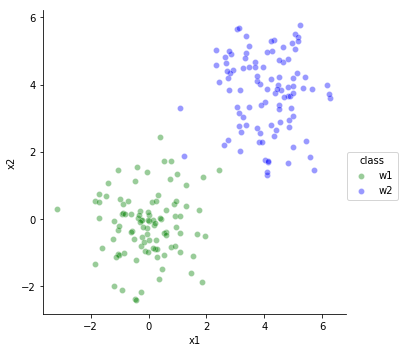

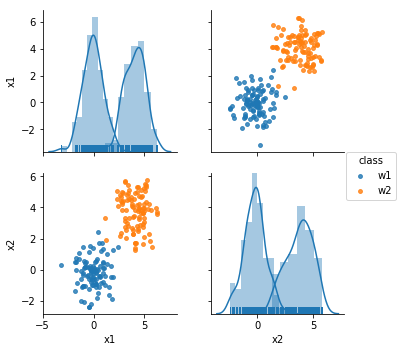

In [4]:
colors = {'w1':'green', 'w2':'blue'}
g = sns.FacetGrid(sample_set, hue='class', palette=colors, size=5)
g.map(plt.scatter,'x1', 'x2', alpha=0.4, linewidth=0.5, edgecolor='white')
g.add_legend()

g = sns.PairGrid(sample_set, hue='class')
g.map_diag(sns.distplot, kde=True, rug=True)
g.map_offdiag(plt.scatter, alpha=0.8,s=15)
g.add_legend()             


In [5]:
# Replace the class string with integer values (1 for class omega_1 and -1 for class omega_2)
training_set = pd.DataFrame.copy(sample_set)
training_set['class'] = training_set['class'].replace('w1', 1)
training_set['class'] = training_set['class'].replace('w2', -1)


In [6]:
class BayesianClassifier():
    
    def __init__(self):
        return 

        
    def train_on_sample(self, df):
        self.df = df
        self.df_class1 = df.loc[df['class'] == 1]
        self.df_class2 = df.loc[df['class'] == -1]

        self.set_stats(df)
        return
    
    def set_stats(self, df):
        stats = self.df.describe()
        stats1 = self.df_class1.describe()
        stats2 = self.df_class2.describe()
        
        self.x1w1_mean = stats1['x1'].get('mean')
        self.x1w1_std = stats1['x1'].get('std')

        self.x1w2_mean = stats2['x1'].get('mean')
        self.x1w2_std = stats2['x1'].get('std')

        self.x2w1_mean = stats1['x2'].get('mean')
        self.x2w1_std = stats1['x1'].get('std')
        
        self.x2w2_mean = stats2['x2'].get('mean')
        self.x2w2_std = stats2['x1'].get('std')
        
        self.prior_w1 = df['class'].value_counts()[1] / stats['class'].get('count') 
        self.prior_w2 = df['class'].value_counts()[-1] / stats['class'].get('count')
        return 

    
    def cond_prob_gaussian(self, x, mu, sig):
        A = (1 / (np.sqrt(2*np.pi*sig**2)))
        B = np.exp(-0.5 * ((x - mu)/sig)**2)        
        return A*B
    

    def conditional_prob_x1w1(self, x1):
        return self.cond_prob_gaussian(x1, self.x1w1_mean, self.x1w1_std)

    def conditional_prob_x1w2(self, x1):
        return self.cond_prob_gaussian(x1, self.x1w2_mean, self.x1w2_std)

    
    def conditional_prob_x2w1(self, x2):
        return self.cond_prob_gaussian(x2, self.x2w1_mean, self.x2w1_std)
        
    def conditional_prob_x2w2(self, x2):
        return self.cond_prob_gaussian(x2, self.x2w2_mean, self.x2w2_std)

    
    
    def predict(self, X):
        
        posterior_w1 = self.prior_w1 * self.conditional_prob_x1w1(X[0]) * self.conditional_prob_x2w1(X[1])
        posterior_w2 = self.prior_w2 * self.conditional_prob_x1w2(X[0]) * self.conditional_prob_x2w2(X[1])
        
        
        if(posterior_w1 >= posterior_w2):
            return 1
        else: 
            return -1
  

In [7]:
bae = BayesianClassifier()
bae.train_on_sample(training_set)

bae.predict([0, 0])

1

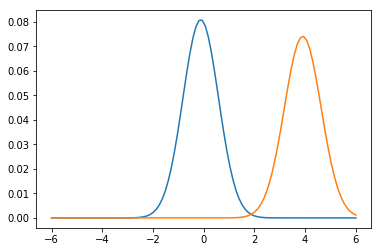

In [8]:
a = np.linspace(-6, 6, 100)
testdf = pd.DataFrame()

x1w1_posterior = np.asarray([bae.conditional_prob_x1w1(item) for item in a])
x2w1_posterior = np.asarray([bae.conditional_prob_x2w1(item) for item in a])
x1w2_posterior = np.asarray([bae.conditional_prob_x1w2(item) for item in a])
x2w2_posterior = np.asarray([bae.conditional_prob_x2w2(item) for item in a])




plt.plot(a, x1w1_posterior*x2w1_posterior*bae.prior_w1, a, x1w2_posterior*x2w2_posterior*bae.prior_w2)

In [96]:
b = np.linspace(-5, 8, 100)
c = np.zeros((b.size, b.size))
headers = "x1 x2 class".split()
df = pd.DataFrame({}, columns=headers)

for idx, i in enumerate(b):
    for idj, j in enumerate(b):
#         c[int(i),int(j)] = bae.predict([i, j])
        dicttemp = {'x1': i, 'x2':j, 'class':bae.predict([i, j])}
        temp = pd.DataFrame(dicttemp, columns=headers, index=[idx*idj+idj])

        df = pd.concat([df, temp])

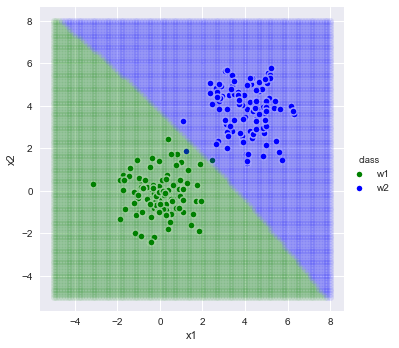

In [128]:
# sns.lmplot('x1', 'x2', data=df, hue='class', fit_reg=False, legend=True, scatter_kws={'alpha':0.1})
# plt.plot(training_set['x1'], training_set['x2'], 'ro', )
class1 = df.loc[df['class']==1]
class2 = df.loc[df['class']==-1]

colors = {'w1':'green', 'w2':'blue'}
g = sns.FacetGrid(sample_set, hue='class', palette=colors, size=5)
g.map(plt.scatter,'x1', 'x2', alpha=1, linewidth=.5, edgecolor='white')
plt.plot(class1['x1'], class1['x2'], 'go', alpha=0.1)
plt.plot(class2['x1'], class2['x2'], 'bo', alpha=0.1)

g.add_legend()


,x1,x2,class
0,-5.000000,-5.000000,1
1,-5.000000,-4.868687,1
2,-5.000000,-4.737374,1
3,-5.000000,-4.606061,1
4,-5.000000,-4.474747,1
5,-5.000000,-4.343434,1
6,-5.000000,-4.212121,1
7,-5.000000,-4.080808,1
8,-5.000000,-3.949495,1
9,-5.000000,-3.818182,1
